# Data owner: Upload data

## Install

In [1]:
#!pip install pysyft

In [3]:
from syft import Worker, MessageStatus
import syft as sy
worker = Worker.named("pandas-test-domain-1", processes=1, reset=True)
root_domain_client = worker.root_client

kj/filesystem-disk-unix.c++:1703: warning: PWD environment variable doesn't match current directory; pwd = /Users/koen/workspace/PySyft


SQLite Store Path:
!open file:///var/folders/q1/ryq93kwj055dlbpngxv1c7z40000gn/T/7bca415d13ed1ec841f0d0aede098dbb.sqlite

> Starting Worker: test-domain-1 - 7bca415d13ed1ec841f0d0aede098dbb - NodeType.DOMAIN - [<class 'syft.core.node.new.user_service.UserService'>, <class 'syft.core.node.new.metadata_service.MetadataService'>, <class 'syft.core.node.new.action_service.ActionService'>, <class 'syft.core.node.new.test_service.TestService'>, <class 'syft.core.node.new.dataset_service.DatasetService'>, <class 'syft.core.node.new.user_code_service.UserCodeService'>, <class 'syft.core.node.new.request_service.RequestService'>, <class 'syft.core.node.new.data_subject_service.DataSubjectService'>, <class 'syft.core.node.new.network_service.NetworkService'>, <class 'syft.core.node.new.policy_service.PolicyService'>, <class 'syft.core.node.new.message_service.MessageService'>, <class 'syft.core.node.new.project_service.ProjectService'>, <class 'syft.core.node.new.data_subject_member_service.Data

## Load data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from dateutil.parser import parse
from pandas._libs.tslibs.timestamps import Timestamp
from syft.core.node.new.util import autocache, PANDAS_DATA

In [5]:
data_path = autocache(f"{PANDAS_DATA}/bikes.csv")

In [6]:
broken_df = pd.read_csv(data_path, encoding = "ISO-8859-1")

In [7]:
broken_df

,Date;Berri 1;Brébeuf (données non disponibles);Côte-Sainte-Catherine;Maisonneuve 1;Maisonneuve 2;du Parc;Pierre-Dupuy;Rachel1;St-Urbain (données non disponibles)
0,01/01/2012;35;;0;38;51;26;10;16;
1,02/01/2012;83;;1;68;153;53;6;43;
2,03/01/2012;135;;2;104;248;89;3;58;
3,04/01/2012;144;;1;116;318;111;8;61;
4,05/01/2012;197;;2;124;330;97;13;95;
...,...
305,01/11/2012;2405;;1208;1701;3082;2076;165;2461
306,02/11/2012;1582;;737;1109;2277;1392;97;1888
307,03/11/2012;844;;380;612;1137;713;105;1302
308,04/11/2012;966;;446;710;1277;692;197;1374


In [8]:
fixed_df = pd.read_csv(data_path, sep=';', encoding='latin1', parse_dates=['Date'], dayfirst=True, index_col='Date')
fixed_df[:3]

,Berri 1,Brébeuf (données non disponibles),Côte-Sainte-Catherine,Maisonneuve 1,Maisonneuve 2,du Parc,Pierre-Dupuy,Rachel1,St-Urbain (données non disponibles)
Date,,,,,,,,,
2012-01-01,35,NaN,0,38,51,26,10,16,NaN
2012-01-02,83,NaN,1,68,153,53,6,43,NaN
2012-01-03,135,NaN,2,104,248,89,3,58,NaN


In [9]:
import numpy as np
from random import randint

def get_mock_int(i, var=10):
    base = 100 + int(np.cos(i/10) * 50)
    return randint(max(base-var, 1),max(1, base+var))

def get_mock_date(i):
    return str(parse('Jun 1 2005').date() + timedelta(days=i))

# some randomness
r = [(randint(1, 40), randint(1, 40)) for _ in range(7)]

def get_mock_row(i):
    res = [get_mock_int(i+r[j][0], r[j][1]) for j in range(7)]
    # add NaNs in the second and 10th col
    res.insert(1, None), res.insert(9, None)
    return res
    

In [10]:
mock = pd.DataFrame(index=[Timestamp(get_mock_date(i)) for i in range(len(fixed_df))],
                    data=[get_mock_row(i) for i in range(len(fixed_df))],
                    columns=fixed_df.columns)

Upload the data

In [11]:
dataset = sy.Dataset(name="test",
                     asset_list=[sy.Asset(name="bikes", data=fixed_df, mock=mock, mock_is_real=False)])
root_domain_client.upload_dataset(dataset)


  0%|                                                                                                                 | 0/1 [00:00<?, ?it/s]

Uploading: bikes


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.78it/s]


<class 'syft.core.node.new.response.SyftSuccess'>: Dataset Added

## Create user account

In [12]:
user = root_domain_client.register(name="Jane Doe", email="jane@caltech.edu",
                            password="abc123", institution="Caltech", website="https://www.caltech.edu/")

In [13]:
# todo: give user data scientist role

In [14]:
guest_domain_client = worker.guest_client

In [15]:
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

# Data scientist: request execution

## Download mock and submit a syft_function

### Get mock

In [16]:
guest_domain_client = worker.guest_client
guest_client = guest_domain_client.login(email="jane@caltech.edu", password="abc123")

In [17]:
ds = guest_domain_client.datasets[0]

In [18]:
asset = ds.assets["bikes"]

In [19]:
df = asset.mock

### Selecting a column

When you read a CSV, you get a kind of object called a DataFrame, which is made up of rows and columns. You get columns out of a DataFrame the same way you get elements out of a dictionary.

Here's an example:

In [20]:
df['Berri 1']

2005-06-01    53
2005-06-02    63
2005-06-03    58
2005-06-04    49
2005-06-05    62
              ..
2006-04-02    93
2006-04-03    87
2006-04-04    94
2006-04-05    89
2006-04-06    73
Name: Berri 1, Length: 310, dtype: int64

### Plotting a column

Just add .plot() to the end! How could it be easier? =)

We can see that, unsurprisingly, not many people are biking in January, February, and March,

<AxesSubplot: >

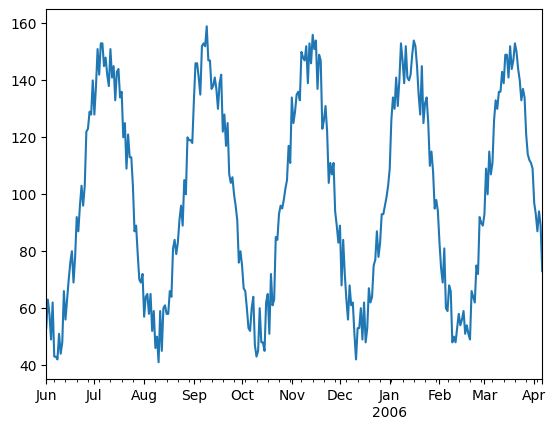

In [21]:
df['Berri 1'].plot()

We can also plot all the columns just as easily. We'll make it a little bigger, too. You can see that it's more squished together, but all the bike paths behave basically the same -- if it's a bad day for cyclists, it's a bad day everywhere.

In [ ]:
df.plot(figsize=(15, 10))

### Putting that all together

Here's the code we needed to write do draw that graph, all together:



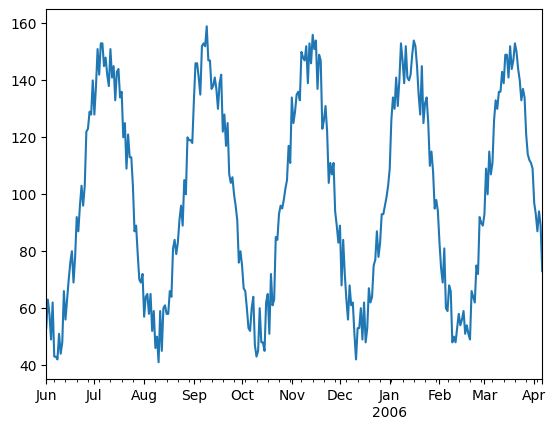

In [23]:
res = df['Berri 1'].plot()

In [24]:
@sy.syft_function(input_policy=sy.ExactMatch(df=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_column(df):
    return df['Berri 1']

Request code execution

In [25]:
req = guest_domain_client.api.services.code.request_code_execution(get_column)


In [26]:
submitted_code = guest_domain_client.code[0]

In [27]:
assert guest_domain_client.api.services.code.get_all()

Create and submit project

In [28]:
new_project = sy.Project(name="My pandas project 2",
                         description="Hi, I would like to plot the Berri 1 column.")

In [29]:
new_project.add_request(obj=submitted_code, permission=sy.UserCodeStatus.EXECUTE)

In [30]:
guest_domain_client.submit_project(new_project)

<class 'syft.core.node.new.response.SyftSuccess'>: Project Submitted

# Data owner: execute function

In [31]:
from syft.core.node.new.project import Project

## Get messages

In [54]:
domain_client = worker.guest_client.login(email="info@openmined.org", password="changethis")

In [55]:
messages = domain_client.api.services.messages.get_all_for_status(MessageStatus.UNDELIVERED)

In [56]:
messages

,type,id,subject,status,created_at,linked_obj
0,syft.core.node.new.messages.Message,467a5c99f45b445d8f9431ddde44d7f3,Approval Request,MessageStatus.UNDELIVERED,2023-05-15 11:13:02,<<class 'syft.core.node.new.request.Request'>:...
1,syft.core.node.new.messages.Message,f223f721a32844a69825e62afab417f5,Project Approval,MessageStatus.UNDELIVERED,2023-05-15 11:13:02,<<class 'syft.core.node.new.project.Project'>:...


In [57]:
project_message = [x for x in messages if issubclass(x.linked_obj.object_type, Project)][0]

In [58]:
request = project_message.link.requests[0]
func = request.changes[0].link
op = func.output_policy_type

In [59]:
func

```python
class UserCode:
  id: str = 7eec8d12402b42ad8af4552a94986fed
  node_uid: str = 7bca415d13ed1ec841f0d0aede098dbb
  user_verify_key: str = ca73726003c3ea2064a51a1cf44cee9f17c17ff3a69e16cab5e7c4550e748cd9
  raw_code: str = "@sy.syft_function(input_policy=sy.ExactMatch(df=asset.mock),
                  output_policy=sy.SingleExecutionExactOutput())
def get_column(df):
    return df['Berri 1']
"
  input_policy_type: str = <class 'syft.core.node.new.policy.ExactMatch'>
  input_policy_init_kwargs: str = {NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): {'df': <UID: 8d14d9c79da84ab6a0f7c6efa085b2fe>}}
  input_policy_state: str = b''
  output_policy_type: str = <class 'syft.core.node.new.policy.OutputPolicyExecuteOnce'>
  output_policy_init_kwargs: str = {}
  output_policy_state: str = b''
  parsed_code: str = "

def user_func_get_column_ca73726003c3ea2064a51a1cf44cee9f17c17ff3a69e16cab5e7c4550e748cd9_c78245a57a0298849aa6e5f18c7bf1d692ee39508e8fd8f8dcf491156ffea0c4(df):

    def get_column(df):
        return df['Berri 1']
    result = get_column(df=df)
    return result
"
  service_func_name: str = "get_column"
  unique_func_name: str = "user_func_get_column_ca73726003c3ea2064a51a1cf44cee9f17c17ff3a69e16cab5e7c4550e748cd9_c78245a57a0298849aa6e5f18c7bf1d692ee39508e8fd8f8dcf491156ffea0c4"
  user_unique_func_name: str = "user_func_get_column_ca73726003c3ea2064a51a1cf44cee9f17c17ff3a69e16cab5e7c4550e748cd9"
  code_hash: str = "c78245a57a0298849aa6e5f18c7bf1d692ee39508e8fd8f8dcf491156ffea0c4"
  signature: str = (df)
  status: str = {NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): <UserCodeStatus.SUBMITTED: 'submitted'>}
  input_kwargs: str = ['df']
  enclave_metadata: str = None

```

In [60]:
get_col_user_function = func.unsafe_function

In [61]:
real_data = domain_client.datasets[0].assets[0].data

In [62]:
real_result = get_col_user_function(df=real_data)

In [63]:
real_result[:3]

Date
2012-01-01     35
2012-01-02     83
2012-01-03    135
Name: Berri 1, dtype: int64

In [64]:
result = request.accept_by_depositing_result(real_result)
result
assert isinstance(result, sy.SyftSuccess)

# Data scientist: fetch result

In [65]:
asset = guest_client.datasets[0].assets[0]

In [66]:
guest_client.api.services.code[0].status

{NodeView(node_name='test-domain-1', verify_key=aec6ea4dfc049ceacaeeebc493167a88a200ddc367b1fa32da652444b635d21f): <UserCodeStatus.EXECUTE: 'execute'>}

<AxesSubplot: >

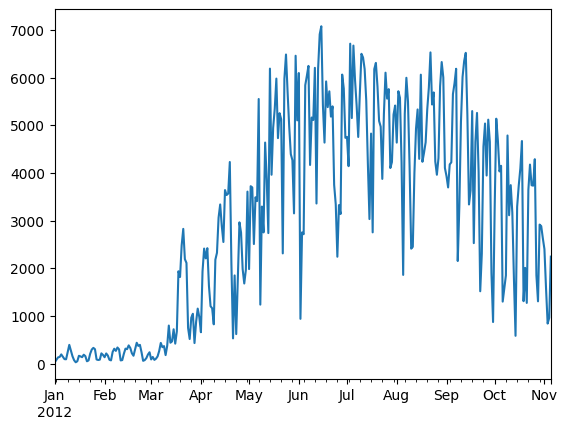

In [68]:
real_result = guest_client.api.services.code.get_column(df=asset)
real_result.plot()